Evaluate the Results of the MOO + ES 

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
from common import RESULTS_YEAR_DIR, RESULTS_OPT_DIR
FILENAME = "results_year.csv"

sns.set_style("whitegrid")
results = pd.read_csv(os.path.join(RESULTS_OPT_DIR,FILENAME))
results.head()

,Unnamed: 0,Gen,PV,Wind,P2H,Sto,re_fraction,ex_el_fraction,ex_heat_fraction,p2h_heat_fraction,total_co2,energy_cost,system_anpv,total_system_costs
0,0,1,229.647042,58.691430,235.722215,279.903344,0.412020,0.587980,0.500748,0.499252,173.570903,15857.878823,71045.526013,86903.404836
1,1,1,265.376599,248.678288,45.898389,379.795703,0.838081,0.161919,0.776663,0.223337,89.291194,220.648025,130716.200559,130936.848584
2,2,1,40.933772,165.622395,277.760063,165.671708,0.417551,0.582449,0.197106,0.802894,169.852024,15748.127106,69815.009248,85563.136354
3,3,1,179.964853,231.355846,163.254721,94.810792,0.717651,0.282349,0.643612,0.356388,108.187683,4466.793783,105113.883638,109580.677420
4,4,1,350.555661,357.842665,34.017685,15.621913,0.819896,0.180104,0.772704,0.227296,92.766723,-8141.329800,161980.127527,153838.797727


Plot the evolution of the points obtained

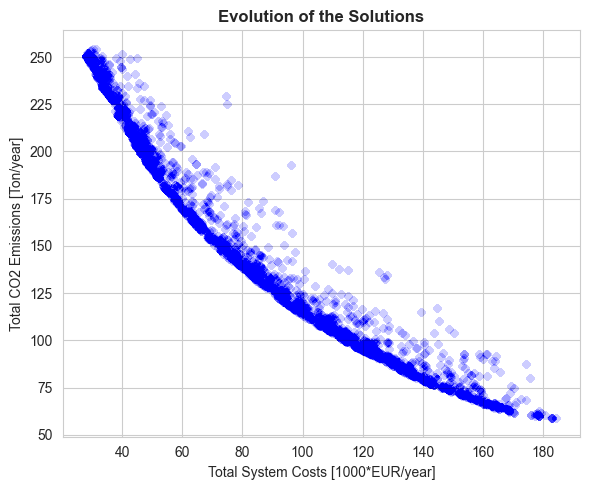

In [36]:

N_GEN =max(results["Gen"])
fig,ax= plt.subplots(figsize=(6,5))
import matplotlib


for i in range(1,N_GEN+1):

    res_gen = results[results["Gen"]==i]
    res_gen =results[results["total_co2"]!=1e9]
    res_gen["total_system_costs"]*=1/1000
    sns.scatterplot(data=res_gen, x="total_system_costs", y = "total_co2", alpha=0.002, edgecolors=None,color="blue")

ax.set_xlabel("Total System Costs [1000*EUR/year]")
ax.set_ylabel("Total CO2 Emissions [Ton/year]")
ax.set_title("Evolution of the Solutions", fontweight="bold")
fig.tight_layout()
fig.savefig(os.path.join(RESULTS_YEAR_DIR,"solutions.png"), dpi=600)

Study Relations Between Indicators

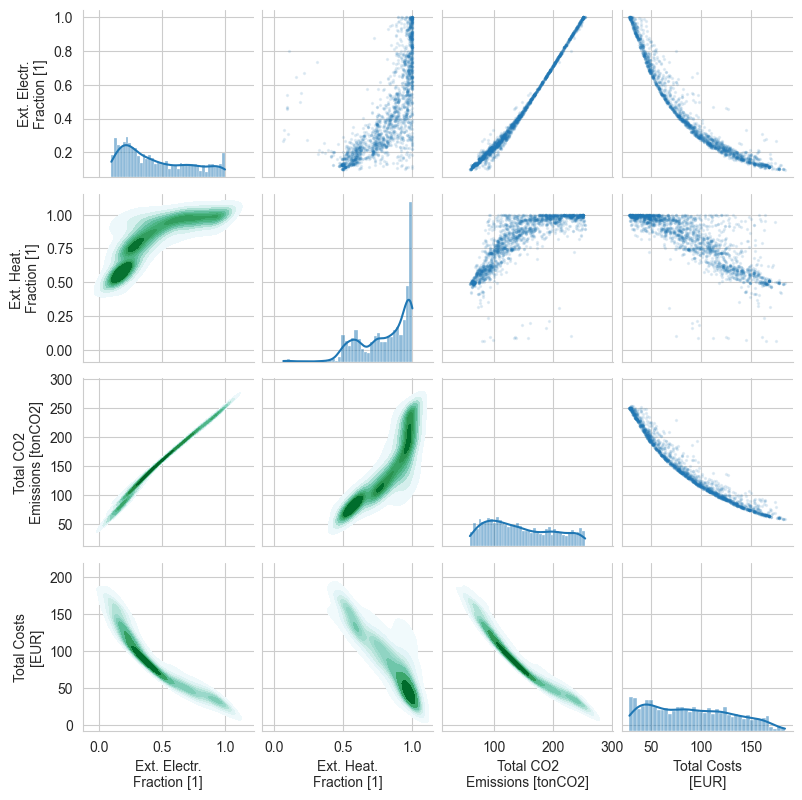

In [37]:
optimal = results[results["Gen"] > 1]

optimal = optimal[optimal["total_co2"] < 1e9]
optimal = optimal[[
    # 'PV', 'Wind', 'P2H', 'Sto',
    'ex_el_fraction', 'ex_heat_fraction', 'total_co2',
    'total_system_costs']]
optimal["total_system_costs"] *= 1/1000

optimal.rename(columns={
    'ex_el_fraction': "Ext. Electr.\nFraction [1]",
    'ex_heat_fraction': "Ext. Heat.\nFraction [1]",
    'total_co2': "Total CO2\nEmissions [tonCO2]",
    'total_system_costs': "Total Costs\n[EUR]"

}, inplace=True)


grid = sns.PairGrid(data=optimal)
grid.fig.set_size_inches(8, 8)


grid = grid.map_upper(plt.scatter, s=2, alpha=0.1)
# grid = grid.map_upper(sns.scatterplot, size=sizes_**2, sizes=(5,10), color = "g")
# grid = grid.map_upper(corr)

grid = grid.map_lower(sns.kdeplot, fill=True, cmap="BuGn")
grid = grid.map_diag(sns.histplot, kde=True,  line_kws={
    'color': 'g'}, bins=40, edgecolor='w')

plt.subplots_adjust(wspace=0.05)
filename = os.path.join(RESULTS_YEAR_DIR, "pairplot.png")
grid.savefig(filename, dpi=900, bbox_inches='tight')

Pareto Front and different sizes of technology


In [38]:
import pandas as pd

def get_pareto_front(df):
    # Add a flag column to identify the Pareto optimal solutions
    df['ParetoOptimal'] = True

    # Iterate over each row to check for dominance
    for i, row in df.iterrows():
        for j, other_row in df.iterrows():
            if i != j:
                if (row[0] > other_row[0] and row[1] > other_row[1]) or (row[0] >= other_row[0] and row[1] > other_row[1]) or (row[0] > other_row[0] and row[1] >= other_row[1]):
                    df.at[i, 'ParetoOptimal'] = False
                    break
    
    # Filter and return only the Pareto optimal solutions
    pareto_front = df[df['ParetoOptimal']]
    
    return pareto_front



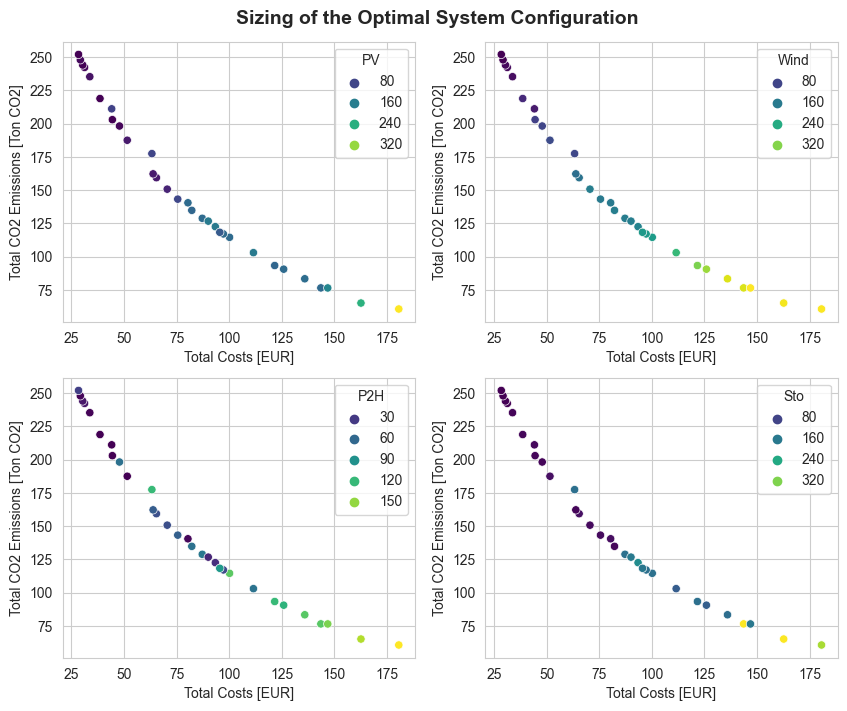

In [39]:
df_last= results[results["Gen"]==max(results["Gen"])]
pareto = get_pareto_front(df_last[["total_co2", "total_system_costs"]])

from copy import deepcopy
df_pareto = deepcopy(df_last)
df_pareto["pareto"] =False
for idx,row in df_pareto.iterrows():
    if row["total_co2"] in [x for x in pareto["total_co2"]]:
        if row["total_system_costs"] in [y for y in pareto["total_system_costs"]]:
            df_pareto.at[idx,"pareto"]=True
df_pareto["pareto"]

df_pareto = df_pareto[df_pareto["pareto"]==True]
df_pareto["total_system_costs"]*=1/1000                    

fig,axs= plt.subplots(2,2,figsize=(10,8))
cols = [ 'PV', 'Wind', 'P2H', 'Sto',
    #'ex_el_fraction', 'ex_heat_fraction'
    ]
ax_= [axs[i][j] for i in range(2) for j in range(2)]

for i in range(4):
    col =  cols[i]
    ax=ax_[i]
    sns.scatterplot(data=df_pareto,x="total_system_costs", y = "total_co2", hue=col, ax=ax, palette="viridis")
    ax.set_xlabel("Total Costs [EUR]")
    ax.set_ylabel("Total CO2 Emissions [Ton CO2]")

fig.suptitle("Sizing of the Optimal System Configuration", fontweight="bold", fontsize=14, y=0.92)


filename = os.path.join(RESULTS_YEAR_DIR, "sizing.png")
fig.savefig(filename, dpi=900, bbox_inches='tight')

Intercept: 612.8411507403302
Slope: -107.81857224615773
y = 612.84 -107.82*log(x)


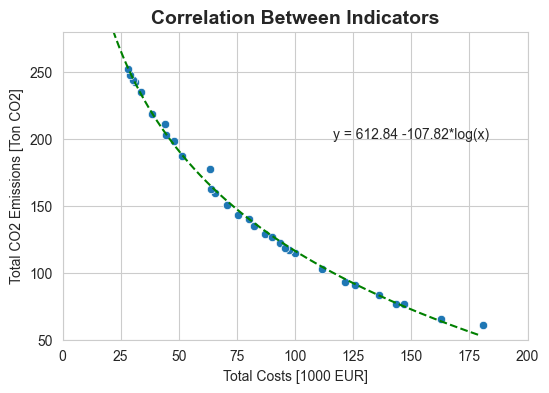

In [40]:
fig,ax= plt.subplots(figsize=(6,4))
sns.scatterplot(data=df_pareto, x="total_system_costs", y= "total_co2")
#ax.set_yscale("log")
import statsmodels.api as sm
from numpy import log

# Prepare the data for linear regression
X = [log(x) for x in df_pareto['total_system_costs']]
y = [y for y in df_pareto['total_co2']]
X = sm.add_constant(X)  # Add a constant term for the intercept

# Create and fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the parameters
intercept = results.params[0]
slope = results.params[1]
import numpy as np
print("Intercept:", intercept)
print("Slope:", slope)
# y = 262.784-1.3452*x
# co2 = 262.74-1.342*ln(cost)
fit = {"x": np.linspace(0,180,200),
       "y": [intercept +slope*log(x) for x in np.linspace(1,180,200)]}
df_fit=pd.DataFrame.from_dict(fit)
sns.lineplot(data=df_fit, x="x", y="y", ax=ax, linestyle="--", color = "g")
ax.set_xlim(left=0, right=200)
ax.set_ylim(bottom=50, top= 280)

ax.set_xlabel("Total Costs [1000 EUR]")
ax.set_ylabel("Total CO2 Emissions [Ton CO2]")
filename = os.path.join(RESULTS_YEAR_DIR, "correl.png")
m = abs(round(slope,2))
b= round(intercept,2)
text = f"y = {b} -{m}*log(x)"
print(text)
ax.annotate(text,xy=(0.5,0.5))

ax.set_title("Correlation Between Indicators", fontweight="bold", fontsize=14)
ax.text(150, 200, text, ha='center')

fig.savefig(filename, dpi=900, bbox_inches='tight')